In [ ]:
import os
import glob
import sklearn
import pandas as pd
import numpy as np
import gdal
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn import metrics 
drive.mount("/content/drive")
import matplotlib.pyplot as plt

Mounted at /content/drive


In [ ]:
#function to read geotiff
def readtiff(filename):
    # @ file name to read
    file = gdal.Open(filename, gdal.GA_ReadOnly)
    band_number = file.RasterCount
    #print(band_number)
    #data = file.GetRasterBand(0,23)
    #print(data)
    array = file.ReadAsArray()
    return array

In [ ]:
#read RS data
RS_file = '/content/drive/MyDrive/Senior Design/Competition /Dataset/new/Sudan_NDVI.tif'
array_NDVI = readtiff(RS_file)
array_shape = array_NDVI.shape
array_result = np.zeros((array_shape[1],array_shape[2]),dtype=int)
file_geo = gdal.Open(RS_file, gdal.GA_ReadOnly)

In [ ]:
#read samples
train_file_noncrop = pd.read_csv("/content/drive/MyDrive/Senior Design/Competition /Samples/Sudan_samples/Sudan_intensity/samples_intensity_Sudan_noncropland_nw.csv",index_col=False)
train_file_noncrop=train_file_noncrop.sample(n=350)

train_file_noncrop_water = pd.read_csv("/content/drive/MyDrive/Senior Design/Competition /Samples/Sudan_samples/Sudan_intensity/samples_intensity_Sudan_noncropland_w.csv",index_col=False)
train_file_noncrop_water =train_file_noncrop_water.sample(n=100) #10% of noncropland
train_file_noncropland = pd.concat([train_file_noncrop_water,train_file_noncrop])

train_file_crop= pd.read_csv("/content/drive/MyDrive/Senior Design/Competition /Samples/Sudan_samples/Sudan_intensity/samples_intensity_Sudan_cropland.csv", index_col=False)


df_SR= pd.concat([train_file_noncropland,train_file_crop])
df_SR= df_SR.drop(["system:index",".geo","landclass"], axis = 1);

df_SR= df_SR.fillna(0)

In [ ]:
from scipy.signal import savgol_filter
def ndvi_reconstruct(df):
  for i in range(len(df)):
    for j in range(len(df.columns)-1):
       if df.iat[i,j] == 0 or  abs(df.iat[i,j-1] - df.iat[i,j]) > 4000 :
              df.iat[i,j] = ((df.iloc[i][1]+df.iloc[i][len(df.columns)-1])/2.0)
       if j == len(df.columns)-1:
                df.iat[i,j] = ((df.iloc[i][j-1]+df.iloc[i][0])/2.0)
       if j != 0 and j != len(df.columns) - 1:
                df.iat[i,j] = ((df.iloc[i][j-1]+df.iloc[i][j+1])/2.0)
  return df

In [ ]:
df_SR = ndvi_reconstruct(df_SR)

In [ ]:
from scipy.signal import savgol_filter
smoothed_NDVI = savgol_filter(df_SR, window_length = 3, polyorder = 2)
series1 = smoothed_NDVI.astype(float)

def find_cycles(Y):   
  row=Y
  l=0
  max=row[0]
  for l in range(24):
    if(row[l]>max):
      max=row[l]
    l=l+1
  if(max<3000):
    return 0

  max_val=0.60*max
  min_val=0.40*max
  maxima = []
  i =0
  while i<row.size:
    if(i==0):
      if(row[i]>=max_val):
        j=i+1;
        while(j!=24): #right traversal
          
          if(row[j]<=min_val):
            maxima.append(i)
            i=i+1
            break
          elif(row[j]>=max_val):
            i=j
            break
          elif(j==23):
            j=j+1
            i=i+1
          else:
            j=j+1
      else:
          i=i+1

    elif(i==23):
      if(row[i]>=max_val):
        j=i-1;
        while(j!=-1): #left traversal 
          if(row[j]<=min_val):
            maxima.append(i)
            i=i+1
            break
          elif(row[j]>=max_val):
            i=i+1
            break
          elif(j==0):
            j=j-1
            i=i+1
          else:
            j=j-1;
      else:
        i=i+1

    elif(i!=24):
      check=False
      # proceed=False
      if(row[i]>=max_val):
        j=i+1
        k=i-1
        while(j!=24): #right traversal
          if(row[j]<=min_val):
            # maxima.append(i)
            check=True
            break
          elif(row[j]>=max_val):
            # proceed=True
            i=j
            k=i-1
            j=j+1
            # break
          else:
            j=j+1;
        while(k!=-1): #left traversal
          if(row[k]<=min_val):
            # maxima.append(i)
            if(check==True):
              maxima.append(i)
              i=i+1
              break
            else:
              i=i+1
              break
          elif(row[k]>=max_val):
            if(k==0):
              i=i+1
            k=k-1
            # i=i+1
            # break
          elif k==0:
            i=i+1
            k=k-1
          else:
            k=k-1;
      else:
        i=i+1
    else:
      i=i+1
  return len(maxima)

In [ ]:
df_filter = pd.DataFrame(series1, columns = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23'])

In [ ]:
df_filter.insert(24,"cycles"," ")

In [ ]:
for i in range(len(df_filter)):
  
  df_filter.cycles.iloc[i] = find_cycles(df_filter.iloc[i])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
class_0 = df_filter[df_filter['cycles']==0]
print(len(class_0.index))
class_1 = df_filter[df_filter['cycles']==1]
print(len(class_1.index))
class_2 = df_filter[df_filter['cycles']==2]
print(len(class_2.index))
class_3 = df_filter[df_filter['cycles']==3]
print(len(class_3.index))

1354
29516
2532
41


In [ ]:
import random
def oversampling(df, n):
  for i in range(n):
    tmp = df.sample()
    for j in range(24):
       tmp.iloc[0,j] += random.randint(-50, 50)
    df = df.append(tmp)
  return df

In [ ]:
class_3 = oversampling(class_3,8)
print(len(class_3.index))

50


0     1034.000000
1     3178.000000
2     4844.000000
3     2422.000000
4     3764.000000
5     4380.000000
6     4693.000000
7     4237.500000
8     3139.250000
9     2509.125000
10    2407.062500
11    2738.031250
12    3599.015625
13    4663.007813
14    6114.003906
15    6865.001953
16    5831.500977
17    3930.750488
18    2778.875244
19    2016.937622
20    1815.968811
21    1555.984406
22    1329.992203
23    1104.000000
Name: 4797, dtype: float64


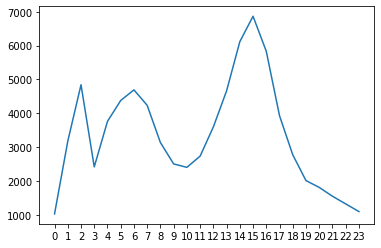

In [ ]:
class_3_plot = class_3.drop(['cycles'], axis=1)
plt.plot(class_3_plot.iloc[32])
plt.plot()
print(class_3_plot.iloc[32])

In [ ]:
class_0=class_0.sample(n=50)
class_1=class_1.sample(n=50)
class_2=class_2.sample(n=50) 
class_3=class_3.sample(n=50) 

In [ ]:
dataset = pd.concat([class_0,class_1,class_2,class_3])

In [ ]:
x=dataset.drop(["cycles"], axis = 1);
y=dataset["cycles"]

In [ ]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle=True )
x_train=x_train.astype('int')
y_train=y_train.astype('int')
x_test=x_test.astype('int')
y_test=y_test.astype('int')

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_clf = RandomForestClassifier(oob_score=True, criterion='entropy',verbose=3)   
rf_clf.fit(x_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomForestClassifier(criterion='entropy', oob_score=True, verbose=3)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score
y_pred = rf_clf.predict(x_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
print("Weighted f1_score= ",f1_score(y_test, y_pred,average='weighted'))
print("Weighted precision = ",precision_score(y_test, y_pred, average='weighted'))

[[12  0  0  0]
 [ 2 15  4  0]
 [ 0  2 12  1]
 [ 0  0  0 18]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        12
           1       0.88      0.71      0.79        21
           2       0.75      0.80      0.77        15
           3       0.95      1.00      0.97        18

    accuracy                           0.86        66
   macro avg       0.86      0.88      0.86        66
weighted avg       0.87      0.86      0.86        66

0.8636363636363636
Weighted f1_score=  0.8603376846161227
Weighted precision =  0.8654205701419323


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [ ]:
import ee

In [ ]:
!pip install -U geemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 5.4 MB/s 
     |████████████████████████████████| 8.8 MB 52.5 MB/s 
     |████████████████████████████████| 98 kB 9.2 MB/s 
     |████████████████████████████████| 46 kB 3.5 MB/s 
     |████████████████████████████████| 55 kB 4.3 MB/s 
     |████████████████████████████████| 3.4 MB 49.2 MB/s 
     |████████████████████████████████| 99 kB 9.6 MB/s 
     |████████████████████████████████| 3.0 MB 43.3 MB/s 
     |████████████████████████████████| 130 kB 33.0 MB/s 
     |████████████████████████████████| 198 kB 69.5 MB/s 
     |████████████████████████████████| 1.2 MB 51.0 MB/s 
     |████████████████████████████████| 1.3 MB 59.1 MB/s 
     |████████████████████████████████| 128 kB 51.9 MB/s 
     |████████████████████████████████| 1.6 MB 53.7 MB/s 
     |████████████████████████████████| 54 kB 2.6 MB/s 
     |████████████████████████████████| 9.

In [ ]:
import geemap
from geemap import ml
from sklearn import ensemble

In [ ]:
geemap.ee_initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=E5qjiyTWNB5_mPK0IKgOR6X2K9mBswJIGxol-xTJviA&tc=pFWzJAJir2xqckpFaPZQ6K1snLGVCXoMyP6KAelp1oY&cc=6vNwmx31QI3r_umhqlich_xnwEoJzgLm6RxKpIXhPd0

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1ARtbsJpWrWhXMX33wvqV0m_frxecDnc6ozc9MinT75Y3z1A_SLfQv8Nstu8

Successfully saved authorization token.


In [ ]:
feature_names = ['nd_p100','nd_p100_1','nd_p100_2','nd_p100_3','nd_p100_4','nd_p100_5','nd_p100_6','nd_p100_7','nd_p100_8','nd_p100_9','nd_p100_10','nd_p100_11','nd_p100_12','nd_p100_13','nd_p100_14','nd_p100_15','nd_p100_16','nd_p100_17','nd_p100_18','nd_p100_19','nd_p100_20','nd_p100_21','nd_p100_22','nd_p100_23']
label = "cycles"

In [ ]:
# convert the estimator into a list of strings
# this function also works with the ensemble.ExtraTrees estimator
trees = ml.rf_to_strings(rf_clf, feature_names)

In [ ]:
# create a ee classifier to use with ee objects from the trees
ee_classifier = ml.strings_to_classifier(trees)

In [ ]:
l8 = ee.Image('projects/ee-g00085636/assets/NDVI_SUDAN_unmasked') #the unmasked image from google earth engine (I converted it into a google earth engine asset first)

In [ ]:
# classify the image using the classifier we created from the local training
# note: here we select the feature_names from the image that way the classifier knows which bands to use
classified = l8.select(feature_names).classify(ee_classifier)

In [ ]:
# display results
Map = geemap.Map(center=(12.8628, 30.2176),zoom=11)

Map.addLayer(
    l8,
    {"bands": ['nd_p100_2','nd_p100_5','nd_p100_7'], "min": -10000, "max": 10000, "gamma": 1.5},
    'image',
)
Map.addLayer(
    classified,
    { "palette": ['#ffffff','008000','ffff00','ff0000']},
    'classification',
)
Map

Map(center=[12.8628, 30.2176], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chi…

In [ ]:
import xgboost as xgb
xgb_cl = xgb.XGBClassifier(objective='multi:softmax', early_stopping_rounds=10)
xgb_cl.fit(x_train,y_train,
           verbose=True)

y_pred = xgb_cl.predict(x_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
print("Weighted f1_score= ",f1_score(y_test, y_pred,average='weighted'))
print("Weighted precision = ",precision_score(y_test, y_pred, average='weighted'))

[[12  0  0  0]
 [ 2 13  6  0]
 [ 0  3 12  0]
 [ 0  0  0 18]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        12
           1       0.81      0.62      0.70        21
           2       0.67      0.80      0.73        15
           3       1.00      1.00      1.00        18

    accuracy                           0.83        66
   macro avg       0.83      0.85      0.84        66
weighted avg       0.84      0.83      0.83        66

0.8333333333333334
Weighted f1_score=  0.8294359203450111
Weighted precision =  0.8386093073593074


In [ ]:
!pip install dtw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for dtw: filename=dtw-1.4.0-py3-none-any.whl size=5315 sha256=c03d4a05cca3734958c1ef12f72605abce98535c8ca12094d496340dddc19d07
  Stored in directory: /root/.cache/pip/wheels/f9/51/54/b7f446e6d4f5be9a66066b59c5030731191260515737be4496
Successfully built dtw


In [ ]:
import dtw

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from scipy.spatial import distance

In [ ]:
def DTW(a, b):   
    an = a.size
    bn = b.size
    pointwise_distance = distance.cdist(a.reshape(-1,1),b.reshape(-1,1))
    cumdist = np.matrix(np.ones((an+1,bn+1)) * np.inf)
    cumdist[0,0] = 0

    for ai in range(an):
        for bi in range(bn):
            minimum_cost = np.min([cumdist[ai, bi+1],
                                   cumdist[ai+1, bi],
                                   cumdist[ai, bi]])
            cumdist[ai+1, bi+1] = pointwise_distance[ai,bi] + minimum_cost

    return cumdist[an, bn]

#train
parameters = {'n_neighbors':[1]}
clf = GridSearchCV(KNeighborsClassifier(metric=DTW), parameters, cv=3, verbose=1)
clf.fit(x_train, y_train)



#evaluate
y_pred = clf.predict(x_test)
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.94      0.81      0.87        21
           2       0.78      0.93      0.85        15
           3       1.00      1.00      1.00        18

    accuracy                           0.92        66
   macro avg       0.93      0.94      0.93        66
weighted avg       0.93      0.92      0.92        66



In [ ]:
for i in range(array_shape[1]):
  #get the data for a line
  temp_array = array_NDVI[:,i,:]
  temp_df = pd.DataFrame(temp_array.T)
  temp_df.columns = pd.DataFrame(x_train).columns.tolist() #unnormalized_x_train (CAUTIOS) 
  array_result[i,:] = rf_clf.predict(temp_df)

Streaming output truncated to the last 5000 lines.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs

In [ ]:
Output_file = '/content/drive/MyDrive/Senior Design/Competition /Dataset/Competition_Dataset/Output/Cropland_Sudan_intensity_smooth2.tif' #change
driver = gdal.GetDriverByName('Gtiff')
outRaster = driver.Create(Output_file, file_geo.RasterXSize, file_geo.RasterYSize, 1, gdal.GDT_Byte)
outRaster.SetGeoTransform(file_geo.GetGeoTransform())
outRaster.SetProjection(file_geo.GetProjection())
outRaster.GetRasterBand(1).WriteArray(array_result)
outRaster = None